In [1]:
# loading EASYMORE
from easymore.easymore import easymore

# initializing EASYMORE object
esmr = easymore()

# specifying EASYMORE objects
# name of the case; the temporary, remapping and remapped file names include case name
esmr.case_name                = 'North_Asia'              
# temporary path that the EASYMORE generated GIS files and remapped file will be saved
esmr.temp_dir                 = '../temporary/'
# name of target shapefile that the source netcdf files should be remapped to
esmr.target_shp               = '../data/target_shapefiles/MERIT_NA_test.shp'
# name of netCDF file(s); multiple files can be specified with *
esmr.source_nc                = '../data/Source_nc_ERA5/ERA5_subset_NorthAsia_*.nc'
# name of variables from source netCDF file(s) to be remapped
esmr.var_names                = ['airtemp']
# rename the variables from source netCDF file(s) in the remapped files;
# it will be the same as source if not provided
esmr.var_names_remapped       = ['temperature']
# name of variable longitude in source netCDF files
esmr.var_lon                  = 'longitude'
# name of variable latitude in source netCDF files
esmr.var_lat                  = 'latitude'
# name of variable time in source netCDF file; should be always time
esmr.var_time                 = 'time'
# location where the remapped netCDF file will be saved
esmr.output_dir               = '../output/'
# format of the variables to be saved in remapped files,
# if one format provided it will be expanded to other variables
esmr.format_list              = ['f4']
# fill values of the variables to be saved in remapped files,
# if one value provided it will be expanded to other variables
esmr.fill_value_list          = ['-9999.00']

# execute EASYMORE
esmr.nc_remapper()



EASYMORE version 0.0.2 is initiated.
no author name is provide and the author name is changed to (author name)!
EASYMORE will remap variable  airtemp  from source file to variable  temperature  in remapped NeCDF file


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


EASYMORE detects that target shapefile is in WGS84 (epsg:4326)
EASYMORE detects that no field for ID is provided in sink/target shapefile
arbitarary values of ID are added in the field ID_t
EASYMORE detects that either of the fields for latitude or longitude is not provided in sink/target shapefile
calculating centroid of shapes in WGS84 projection;
for better appximation use the easymore equal area centroid function to preprocess target shapefile
EASYMORE detects that no field for latitude is provided in sink/target shapefile
latitude values are added in the field lat_t
EASYMORE detects that no field for longitude is provided in sink/target shapefile
longitude values are added in the field lon_t


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]


it seems everything is OK with the sink/target shapefile; added to EASYMORE object target_shp_gpd
EASYMORE will save standard shapefile for EASYMORE claculation as:
../temporary/North_Asia_target_shapefile.shp
EASYMORE detects that the varibales from the netCDF files are identicalin dimensions of the varibales and latitude and longitude
EASYMORE detects that all the varibales have dimensions of:
['time', 'latitude', 'longitude']
EASYMORE detects that the longitude varibales has dimensions of:
['longitude']
EASYMORE detects that the latitude varibales has dimensions of:
['latitude']
EASYMORE detects case 1 - regular lat/lon
max difference of lat values in source nc files are :  0.0
max difference of lon values in source nc files are :  0.0
EASYMORE is creating the shapefile from the netCDF file and saving it here:
../temporary/North_Asia_source_shapefile.shp


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1638: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:1

inside shp_lon_correction, no crs is provided for the shapefile; EASYMORE will allocate WGS84 to correct for lon above 180


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1638: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/pandas/core/dtypes/cast.py

------REMAPPING------
netcdf output file will be compressed at level 4
Removing existing remapped .nc file.
Remapping ../data/Source_nc_ERA5/ERA5_subset_NorthAsia_19800101.nc to ../output/North_Asia_remapped_1980-01-01-00-00-00.nc
Started at date and time 2021-08-09 19:35:37.323462
Ended   at date and time 2021-08-09 19:35:37.542422
------


<xarray.Dataset>
Dimensions:      (time: 24, ID: 5244)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-01 ... 1980-01-01T23:00:00
  * ID           (ID) float64 1.0 2.0 3.0 4.0 ... 5.242e+03 5.243e+03 5.244e+03
Data variables:
    latitude     (ID) float64 ...
    longitude    (ID) float64 ...
    temperature  (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by author name
    License:      
    History:      Created Mon Aug  9 19:35:37 2021
    Source:       Case: North_Asia; remapped by script from library of Sherva...


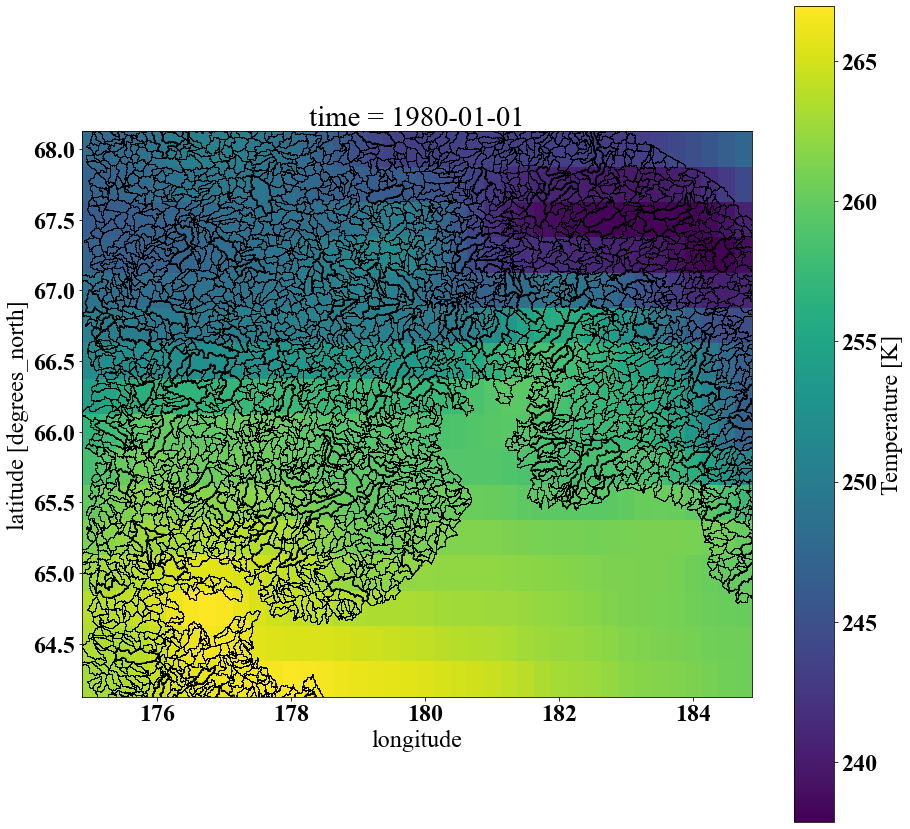

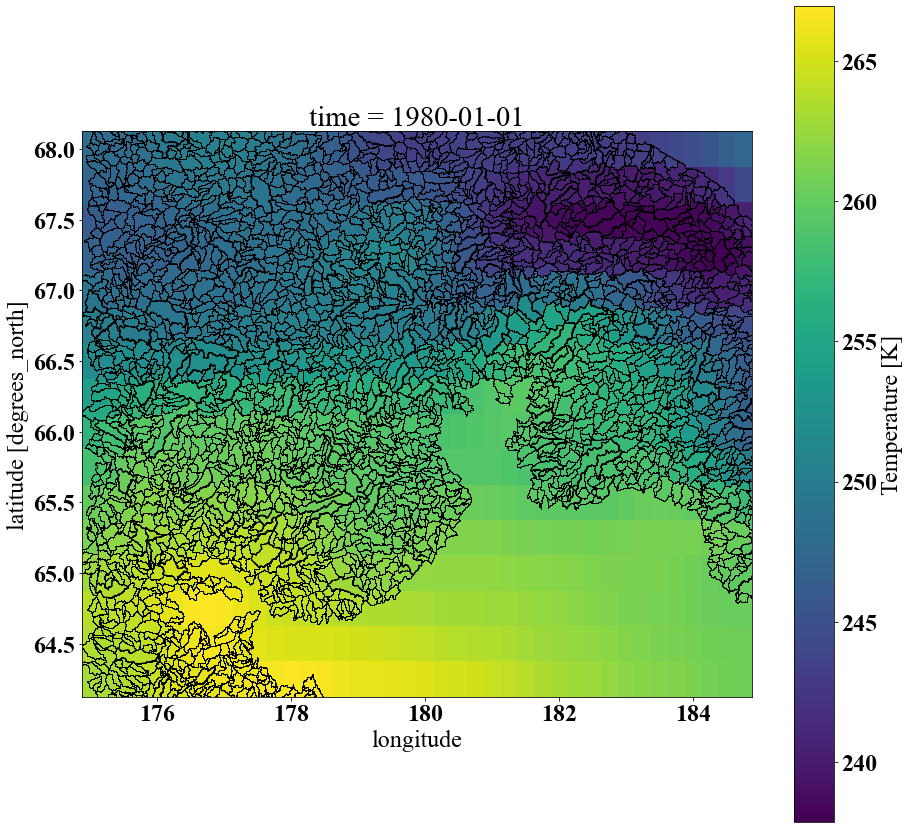

In [2]:
# visualize the result
import geopandas as gpd
import xarray as xr
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)

# visualize the original netCDF for the first file, first time step
shp_target = gpd.read_file(esmr.target_shp) # load the target shapefile
# load the first source netcdf file
nc_name = sorted(glob.glob(esmr.source_nc))
ds_source = xr.open_dataset(nc_name[0])
# subset the region of interest:
lat_lim = np.array([   60  ,   75.0 ]) # limit for lat
lon_lim = np.array([  170  ,  190.5 ]) # limit for lon

lat_lim = np.array([   64  ,   68.0 ]) # limit for lat
lon_lim = np.array([  175  ,  185.0 ]) # limit for lon

lats = np.array(ds_source.variables[esmr.var_lat][:] )
lons = np.array(ds_source.variables[esmr.var_lon][:])
lat_low = np.argmin( np.abs( lats - lat_lim[0] ) )
lat_up = np.argmin( np.abs( lats - lat_lim[1] ) )
lon_low = np.argmin( np.abs( lons - lon_lim[0] ) )
lon_up = np.argmin( np.abs( lons - lon_lim[1] ) )
if lat_up < lat_low:
    temp = lat_low
    lat_low = lat_up
    lat_up = temp
if lon_up < lon_low:
    temp = lon_low
    lon_low = lon_up
    lon_up = temp
ds_source = ds_source.isel(latitude=np.arange(lat_low,lat_up))
ds_source = ds_source.isel(longitude=np.arange(lon_low,lon_up))
# plotting
f, axes = plt.subplots(1,1,figsize=(15,15))
cs = ds_source.airtemp[0,:,:].plot( ax = axes)
shp_target.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1, ax = axes)
plt.savefig('../fig/Example1_A_p.png')

# visualize the remapped netCDF for the first file, first time step
# target nc file
nc_names = sorted(glob.glob (esmr.output_dir + esmr.case_name + '*.nc'))
ds       = xr.open_dataset(nc_names[0]) # the first netcdf file
print(ds)
values   = ds.temperature [0,:] # the first time frame of the first 
IDs      = ds.ID [:] # get the ID
# create a data frame for the model simulation
df = pd.DataFrame()
df ['value'] = values
df ['ID_t']    = IDs  # .astype(int)
df = df.sort_values (by = 'ID_t')
# load the shape file target that is generated by EASYMORE (with consistent IDs)
shp_target = gpd.read_file(esmr.temp_dir+ esmr.case_name + '_target_shapefile.shp') # load the target shapefile
shp_target ['ID_t'] = shp_target ['ID_t'].astype(float)
shp_target = shp_target.sort_values(by='ID_t')# sort on values
shp_target = pd.merge_asof(shp_target, df, on='ID_t', direction='nearest')
shp_target = shp_target.set_geometry('geometry') #bring back the geometry filed; pd to gpd
# plotting
f, axes = plt.subplots(1,1,figsize=(15,15))
ds_source.airtemp[0,:,:].plot( ax = axes)
ds_source.airtemp[0,:,:].plot( ax = axes, alpha = 1, add_colorbar=False,\
                               vmax = cs.colorbar.vmax,\
                               vmin = cs.colorbar.vmin)
shp_target.plot(column= 'value', edgecolor='k',linewidth = 1, ax = axes,\
                               vmax = cs.colorbar.vmax,\
                               vmin = cs.colorbar.vmin )#
plt.savefig('../fig/Example1_B_p.png') 

